### Učitavanje biblioteka

In [70]:
import math
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import confusion_matrix

### Učitavanje skupa podataka

In [75]:
data = pd.read_csv('dataset.csv')

In [76]:
data.head()

,Unnamed: 0,emotion,pixels
0,0,1,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
1,1,0,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
2,2,0,85 84 90 121 101 102 133 153 153 169 177 189 1...
3,3,1,39 75 78 58 58 45 49 48 103 156 81 45 41 38 49...
4,4,1,219 213 206 202 209 217 216 215 219 218 223 23...


### Prikaz skupa podataka

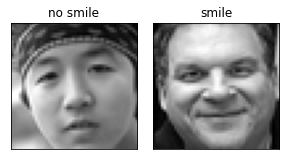

In [77]:
#označili smo s riječi "smile" svaki podataka na kojemu se osoba smije i s "no smile" svaki podatak na kojemu se osoba ne smije
emotion_label_to_text={0:'smile',1:'no smile'}
#želimo prikazati po jednu sliku od obe emocije koje imamo tj. jednu sliku smijeha i jednu bez smijeha 
fig = plt.figure(1, (14,14))
k = c = 0
for i in data["emotion"]:
    if i == 0 or i == 1:
        c+=1
    for j in range(1):
        k += 1
        px = data[data.emotion==i].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        ax = plt.subplot(7,7, k)
        ax.imshow(px , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[i])
        plt.tight_layout()
    if c == 2:
        break

### Pretvaranje csv dokumenta u formu koju možemo koristiti za naš problem

In [78]:
X = data.pixels.apply(lambda x: np.array(x.split(' ')).astype('float32'))
X = np.stack(X, axis=0)
Y = np.array(data['emotion'])

In [79]:
X #slike su crno bijele pa je svaki pixel broj 0-255 kao nijansa između bijele i crne

array([[  4.,   0.,   0., ...,  30.,  29.,  30.],
       [ 77.,  78.,  79., ..., 125.,  67.,  68.],
       [ 85.,  84.,  90., ...,  58.,  73.,  84.],
       ...,
       [ 50.,  36.,  17., ..., 223., 221., 216.],
       [178., 174., 172., ...,   0.,   0.,   0.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.]], dtype=float32)

# Predobrada
Obrada lica 

In [80]:
#ugrađene opencv klase za detekciju lica na slici
eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [81]:
#funkcija za obradu lica
def faceAlignment(image):
  size = image.shape
  #širina i visina slike
  height, width = image.shape[:2]
  #računanje središta slike
  center = (width // 2, height // 2)
  
  #od očiju stvaramo varijable (pomoću ugrađene klase) kako bi ih kasnije mogli koristiti
  eyes = eyeCascade.detectMultiScale(image, 2, 10)
  if len(eyes) == 2 : 
    i=0
    #proces razdvajanja lijevog i desnog oka u dvije zasebne varijable iz varijable eyes
    for (e1 , e2,  e3,  e4) in eyes:
      if i == 0:
        eye1 = (e1, e2, e3, e4)
      else:
        eye2 = (e1, e2, e3, e4)
      i += 1
    if eye1[0] > eye2[0]:
      leftEye = eye2
      rightEye = eye1
    else:
      leftEye = eye1
      rightEye = eye2
        
    #pronalazak središa oba oka
    rightEyeCenter = (int(rightEye[0] + (rightEye[2]/2)), int(rightEye[1] + (rightEye[3]/2)))
    rightEyeX = rightEyeCenter[0]
    rightEyeY = rightEyeCenter[1]
    
    leftEyeCenter = (int(leftEye[0] + (leftEye[2] / 2)), int(leftEye[1] + (leftEye[3] / 2)))
    leftEyeX = leftEyeCenter[0] 
    leftEyeY = leftEyeCenter[1]
    
    deltaX = rightEyeX - leftEyeX
    deltaY = rightEyeY - leftEyeY
    angle = np.arctan(deltaY/deltaX)
    angle = (angle * 180) / np.pi
    #definiranje nove matrice za rotaciju oko središta slike
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    #primjena rotacije na našu sliku uz pomoć matrice M koju smo definirali i ugrađene funkcije
    image = cv2.warpAffine(image, M, (width, height))

    #ponovna detekcija lica s ugrađenom klasom
    faces = faceCascade.detectMultiScale(image, 2, 10)
    if len(faces) > 0 : 
      (x,y,width,height) = faces[0]
      image = image[y:y+height, x:x+width]

  image = cv2.resize(image,size) 
  return image

### Primjena definirane funkcije na naš skup podataka

In [82]:
XNew = []
for i in range(X.shape[0]):
  image = np.array(X[i]).reshape(48,48)
  image = np.array(image, dtype='uint8')
  image = faceAlignment(image)
  XNew.append(np.array(image).reshape(48*48))
X = np.array(XNew)

### Podjela podataka na skup za treniranje i testiranje u omjeru 75:25


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

### Skaliranje podataka pomoću ugrađenog StandardScaler-a

In [84]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32))
X_test = scaler.transform(X_test.astype(np.float32))

# SVM - metoda potpornih vektora

In [85]:
clf = SVC().fit(X_train,y_train) #izradili smo model clf i fit-amo ga na skup za treniranje 
clf.score(X_test , y_test) #potom ga primjenimo na skup za testiranje i ispišemo učinak

0.7692915459573347

### Prikaz matrice zabune dobivenih rezultata

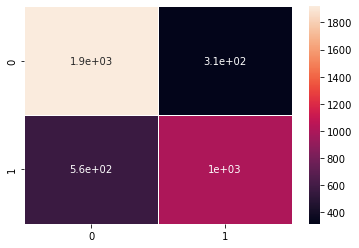

In [86]:
y_hat = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_hat) #za matricu zabune 
sns.heatmap(cf_matrix, linewidths=1, annot=True) #crtanje matrice zabune
plt.show() 